## This script fits simple cross validated SVM using single fit and alpy

## It should be straightforward to go from this script to running experiments on any fingerprint/compound pair

In [63]:
% load_ext autoreload
% autoreload 2
import matplotlib.pylab as plt
% matplotlib inline
import sys
import seaborn
sys.path.insert(0, "../mlls2015")
sys.path.insert(0, "..")
import training_data
from models.cv import AdaptiveGridSearchCV
from training_data.datasets import CVBaseChemDataset
import bunch
import numpy as np
from bunch import Bunch
import os
import logging
from experiments.utils import wac_score
from misc.utils import config_log_to_file

import copy
from models.balanced_models import *

import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.svm import SVC

import alpy_addons
from alpy_addons.active import ActiveLearner
from alpy.datasets.generate import get_2d_gaussians
from alpy_addons.monitors import *
from alpy.oracle import SimulatedOracle
from alpy.strategy import UncertaintySampling, PassiveStrategy

from six import iteritems

from alpy_addons.strategy import UncertaintySampling
from alpy.utils import mask_unknowns

from sklearn.grid_search import GridSearchCV

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [77]:
opts = Bunch({"C_min": -7, 
              "C_max": 6,
              "max_iter": 80000000,
              "n_folds": 5, 
              "preprocess": "clip01", #"max_abs", 
              "fold": 2, 
              "compound": "SERT", 
              "representation": "MACCS", 
              "jaccard": 0, 
              "rng": 777, 
              "name": "test_svm_al",
              "batch_size": 100,
              "output_dir": "/Users/kudkudak/code/mlls2015/"})

In [78]:
config_log_to_file(os.path.join(opts.output_dir, opts.name + ".log"), clear_log_file=True)
logger = logging.getLogger("fit_svm")
logger.info(opts.__dict__)
logger.info(opts.name)

INFO:fit_svm:{}
INFO:fit_svm:test_svm_al


In [79]:
data = CVBaseChemDataset(compound=opts.compound, representation=opts.representation, n_folds=opts.n_folds, rng=opts.rng,
                       preprocess=opts.preprocess)
(X_train, y_train), (X_valid, y_valid) = data.get_data(fold=opts.fold)
if opts.jaccard:
    K_train, K_valid = calculate_jaccard_kernel(data=data, fold=opts.fold)

In [80]:
y_train_masked = mask_unknowns(y_train, np.random.choice(X_train.shape[0], size=X_train.shape[0] - 100, replace=False))

In [81]:
def wac_scoring(estimator, X, y):
    return wac_score(y, estimator.predict(X))

In [82]:
m = AdaptiveGridSearchCV(d=1, 
                       estimator=SVC(random_state=opts.rng, kernel='precomputed', max_iter=opts.max_iter), 
                       param_grid = 
                           {
                             "C": [10**c for c in range(opts.C_min, opts.C_max + 1)]}, 
                       cv=3, 
                       scoring=wac_scoring, 
                       error_score=0.)

In [83]:
def tanimoto(X, W, b=None):
    if not hasattr(X, "toarray"):
        W = W.toarray()

    XW = X.dot(W.T)
    XX = X.multiply(X).sum(axis=1).reshape(-1, 1)
    WW = W.multiply(W).sum(axis=1).reshape(1, -1)
    return XW.toarray() / (XX+WW-XW)

In [84]:
K_train = tanimoto(X_train, X_train)
K_valid = tanimoto(X_valid, X_train)

In [85]:
K_train.shape

(4231, 4231)

In [86]:
uncert_model = ActiveLearner(strategy=UncertaintySampling(),
                             random_state=opts.rng,
                             batch_size=opts.batch_size,
                              oracle=SimulatedOracle(sample_budget=np.inf),
                              estimator=m)

In [87]:
monitors = []

monitors.append(MetricMonitor(name="wac_score",
                        short_name="wac",
                        function=wac_score,
                        ids="all",
                        frequency=1))


monitors.append(MetricMonitor(name="wac_score_labeled",
                        short_name="wac_labeled",
                        function=wac_score,
                        ids="known",
                        frequency=1))

monitors.append(MetricMonitor(name="wac_score_unlabeled",
                        short_name="wac_unlabeled",
                        function=wac_score,
                        ids="unknown",
                        frequency=1))

monitors.append(MetricMonitor(name="wac_score_valid",
                        short_name="wac_valid",
                        function=wac_score,
                        frequency=1,
                        X=K_valid,
                        y=y_valid))

monitors.append(SimpleLogger(batch_size=opts.batch_size))

monitors.append(EstimatorMonitor(only_params=True))

In [88]:
uncert_model.fit(K_train, y_train_masked, monitors=monitors)

INFO:alpy_addons.monitors:iter 0
INFO:alpy_addons.monitors:iter 100
INFO:alpy_addons.monitors:iter 200
INFO:alpy_addons.monitors:iter 300
INFO:alpy_addons.monitors:iter 400
INFO:alpy_addons.monitors:iter 500
INFO:alpy_addons.monitors:iter 600
INFO:alpy_addons.monitors:iter 700
INFO:alpy_addons.monitors:iter 800
INFO:alpy_addons.monitors:iter 900
INFO:alpy_addons.monitors:iter 1000
INFO:alpy_addons.monitors:iter 1100
INFO:alpy_addons.monitors:iter 1200
INFO:alpy_addons.monitors:iter 1300
INFO:alpy_addons.monitors:iter 1400
INFO:alpy_addons.monitors:iter 1500
INFO:alpy_addons.monitors:iter 1600
INFO:alpy_addons.monitors:iter 1700
INFO:alpy_addons.monitors:iter 1800
INFO:alpy_addons.monitors:iter 1900
INFO:alpy_addons.monitors:iter 2000
INFO:alpy_addons.monitors:iter 2100
INFO:alpy_addons.monitors:iter 2200
INFO:alpy_addons.monitors:iter 2300
INFO:alpy_addons.monitors:iter 2400
INFO:alpy_addons.monitors:iter 2500
INFO:alpy_addons.monitors:iter 2600
INFO:alpy_addons.monitors:iter 2700
INFO

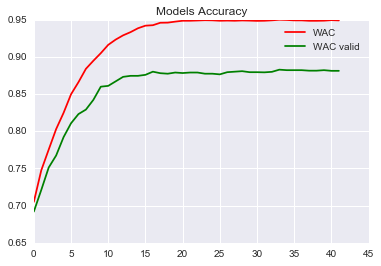

In [89]:
### Plot model accuracy
plt.clf()
unc_wac = uncert_model._monitor_outputs['wac']
unc_wac_valid = uncert_model._monitor_outputs['wac_valid']
t = np.arange(len(unc_wac))
p1 = plt.plot(t, unc_wac, 'r')
p2 = plt.plot(t, unc_wac_valid, 'g')
plt.legend((p1[0], p2[0]), ('WAC', 'WAC valid'), loc='best')
plt.title('Models Accuracy')
plt.show()

In [90]:
def generate_time_report(monitor_outputs):
    # Returns dict with percentage/amount of time spent in each section (all keys with "_time" suffix)
    report = {}
    total_time = float(sum(monitor_outputs['iter_time']))
    for k in monitor_outputs:
        if k.endswith("_time"):
            report[k] = [sum(monitor_outputs[k]), sum(monitor_outputs[k]) / total_time]
    return report

In [91]:
generate_time_report(uncert_model._monitor_outputs)

{'est_mon_time': [0.03255581855773926, 0.0006484061371893269],
 'fit_time': [9.67650055885315, 0.1927244537792397],
 'iter_time': [50.20899200439453, 1.0],
 'oracle_time': [0.04248356819152832, 0.0008461346562745166],
 'simple_logger_time': [0.032590389251708984, 0.0006490946730987254],
 'strategy_time': [10.31149959564209, 0.20537157158501765],
 'wac_labeled_time': [7.908846139907837, 0.15751852057128765],
 'wac_time': [11.136607885360718, 0.22180504807557158],
 'wac_unlabeled_time': [4.341932773590088, 0.08647719462701145],
 'wac_valid_time': [2.079054117202759, 0.041408003511020294]}

In [ ]:
# TODO: write test that will:
# - check repeatibility of whole AL experiment
# - check that final accuracy is SAME as fitting just single estimator